Mathieu Laversin 

EPF 5e année en école d'ingénieur(e)s. Montpellier. 

### <span style="color:#055C9D"> Study of skin's cancer :  </span> 

Objectif : Réunir les informations des 2 années en un long projet 

1. Objectifs, taux de mortalités, comment on attrape le cancer de la peau. 

2. Data Cleaning

    1. Opérations

    2. Scaling

    3. Vizualisations

3. Machine Learning

    1. Modèle de clustering / classifier KNN or LightGBM Classifier.  
    
4. CNN (tensorflow, keras)

    1. CNN

5. Mot sur le cours, essaie 

    1. Remerciement et projet futur. 

    2. Essaie de lier avec les graphs 
    
    3.  page 145 du livre

### What is the skin cancer ? 

Skin cancer is a widespread pathology, with approximately 80,000 cases diagnosed each year in France. Among all skin cancers, basal cell carcinomas represent 70% of diagnosed cases, squamous cell carcinomas 20% and melanomas 10% of cases


Inspiration of the CNN : https://www.kaggle.com/code/gcdatkin/skin-cancer-image-classification/notebook


### What are the possible labels ? 

From the dataset provider:

0: nv - Melanocytic nevi : pigmented skin lesion consisting of melanocytes and at high risk of malignant transformation

1: mel - Melanoma : A cancerous (malignant) tumor is a group of cancerous cells that can invade and destroy nearby tissue

2: bkl - Benign keratosis-like lesions : A seborrheic keratosis (seb-o-REE-ik ker-uh-TOE-sis) is a common noncancerous (benign) skin growth.

3: bcc - Basal cell carcinoma : Type of cancer, Basal cell carcinoma often appears as a slightly transparent bump on the skin, though it can take other forms.

4: akiec - Actinic keratoses and intraepithelial carcinoma / Bowen's disease : common forms of sun-damage where abnormal cells have developed in the top layer of the skin (the epidermis) from excessive sun exposure

5: vasc - Vascular lesions :Vascular lesions are relatively common abnormalities of the skin and underlying tissues, more commonly known as birthmarks

6: df - Dermatofibroma : A dermatofibroma is a common benign fibrous nodule usually found on the skin of the lower legs

### Libraries needed for the project 

In [192]:
#Preprocessing the dataset
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, classification_report,precision_score
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

#Transfert learning 
#from keras.applications.vgg16 import VGG16, preprocess_input

In [ ]:
from files.plot import plot_graphs

Import the data

In [377]:
data = pd.read_csv('data/Tumeurs.csv')
data

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,pixel0010,pixel0011,pixel0012,pixel0013,pixel0014,pixel0015,pixel0016,pixel0017,pixel0018,pixel0019,pixel0020,pixel0021,pixel0022,pixel0023,pixel0024,pixel0025,pixel0026,pixel0027,pixel0028,pixel0029,pixel0030,pixel0031,pixel0032,pixel0033,pixel0034,pixel0035,pixel0036,pixel0037,pixel0038,pixel0039,...,pixel0745,pixel0746,pixel0747,pixel0748,pixel0749,pixel0750,pixel0751,pixel0752,pixel0753,pixel0754,pixel0755,pixel0756,pixel0757,pixel0758,pixel0759,pixel0760,pixel0761,pixel0762,pixel0763,pixel0764,pixel0765,pixel0766,pixel0767,pixel0768,pixel0769,pixel0770,pixel0771,pixel0772,pixel0773,pixel0774,pixel0775,pixel0776,pixel0777,pixel0778,pixel0779,pixel0780,pixel0781,pixel0782,pixel0783,label
0,169,171,170,177,181,182,181,185,194,192,188,190,185,181,188,189,182,180,171,171,178,156,151,157,151,159,167,165,177,176,176,176,179,186,170,182,198,190,196,191,...,179,175,179,186,189,186,153,137,146,164,171,149,167,169,166,171,175,193,198,199,197,185,172,188,199,199,194,191,184,176,184,186,185,180,157,140,140,159,165,2
1,19,57,105,140,149,148,144,155,170,170,182,183,180,179,180,179,180,173,167,171,171,171,160,150,126,102,63,46,34,81,124,149,155,135,136,155,167,182,190,191,...,196,184,172,173,155,145,131,113,68,27,16,50,51,74,109,129,141,163,183,179,175,183,183,177,176,179,188,184,185,181,172,175,160,144,114,89,47,18,18,2
2,155,163,161,167,167,172,155,152,165,175,175,164,170,171,158,143,144,136,154,167,168,171,165,158,150,147,138,116,163,164,167,156,153,158,167,171,184,190,170,161,...,190,177,163,165,166,166,171,165,154,143,127,151,153,150,165,173,173,177,177,181,182,186,187,189,189,188,184,187,185,162,163,178,157,166,167,148,141,136,115,2
3,25,71,116,139,136,153,148,161,172,162,159,176,173,169,156,159,170,164,163,159,164,161,156,144,127,93,57,40,48,97,136,151,148,155,161,169,176,161,151,170,...,166,166,148,148,144,141,125,97,56,20,14,43,47,70,97,128,144,151,157,159,161,167,160,161,163,164,151,161,170,142,125,135,138,137,111,71,32,16,16,2
4,129,162,181,196,205,208,205,213,225,224,222,227,233,230,231,230,241,239,244,247,242,238,239,239,233,211,180,144,145,173,187,195,203,210,210,213,224,224,222,230,...,206,214,209,206,182,197,203,205,205,179,131,99,139,177,193,201,206,197,185,201,197,205,210,214,212,215,209,205,207,211,210,197,172,190,195,193,181,147,88,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,172,171,173,175,164,187,207,210,208,206,215,210,211,204,192,193,196,195,200,198,200,220,220,199,198,203,199,200,194,200,199,203,165,158,184,195,182,176,188,200,...,202,205,214,218,214,215,195,190,200,200,195,194,207,214,215,218,220,207,206,207,210,211,207,206,205,204,205,201,208,210,210,217,221,209,185,187,192,192,192,0
10011,2,34,108,116,114,119,131,139,139,145,168,179,183,190,172,166,186,183,178,176,174,168,155,141,86,43,36,28,16,72,117,107,118,136,134,139,158,174,178,176,...,195,187,180,180,160,150,160,136,124,61,4,52,111,151,168,175,178,182,198,178,191,194,182,183,189,189,187,173,176,184,173,169,168,168,143,138,83,23,3,0
10012,122,154,162,170,179,197,200,195,202,199,202,208,218,235,233,236,234,224,220,204,171,178,195,208,208,175,141,116,138,177,179,178,192,205,213,210,214,216,227,212,...,224,229,222,217,199,203,212,210,188,172,174,167,186,189,212,223,225,227,226,230,220,207,221,211,218,213,177,192,219,223,221,215,205,187,209,198,187,164,156,0
10013,137,143,141,139,147,152,155,152,155,159,160,168,167,164,173,176,177,182,179,174,181,166,176,180,171,164,166,170,132,135,133,145,152,156,159,148,155,161,164,169,...,186,186,182,170,176,183,172,171,179,174,178,135,148,150,155,168,166,164,169,168,161,166,167,163,156,158,157,175,180,178,172,171,175,183,177,170,169,166

We actually don't need to describe the dataset, because it's composed of 10015 rows and 785 columns. That's exactly 784 columns of pixels because we should have 28x28 images and 1 labels for the prediction (as we described in the introduction). 

### Preprocessing : Cleaning

In [119]:
#Let's see if the data contains some 
data.isna().sum().sum()

0

In [121]:
count_nan = data.isnull().sum()
 
# printing the number of values present
# in the column
print('Number of NaN values present: ' + str(count_nan))

Number of NaN values present: pixel0000    0
pixel0001    0
pixel0002    0
pixel0003    0
pixel0004    0
            ..
pixel0780    0
pixel0781    0
pixel0782    0
pixel0783    0
label        0
Length: 785, dtype: int64


The dataset was totaly cleaned when I take it on kaggle. That's totally normal when we work with images. The range of the images is between 0 and 255. 

In [122]:
y = data['label'].copy()
X = data.drop('label', axis=1).copy()

To have less computation, and reduce the range, let's scale the X containing the images. 

In [123]:
X = np.array(X)
X = X.reshape(10015,784)

#Scaled
X = StandardScaler().fit_transform(X)


Let's see how many type of skin cancer we have in this data set. 

In [124]:
y.value_counts()

4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: label, dtype: int64

It seems to be right with the description When they said that basal cell carcinomas represent 70% of diagnosed cases, squamous cell carcinomas 20% and melanomas 10% of cases. It's represative in this dataset.  

In [125]:
#Let's name our label with the encoded label they have with a dicitonary 
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}

Let's have some fun ! And plot the first images of the dataset


In [ ]:
#plot the 9 first images with their label
X = np.array(X)
images = X.reshape(-1, 28, 28, 1)
plot = plt.figure(figsize=(10, 10))
for i in range(9):
    plot.add_subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(label_mapping[y[i]])
    plt.axis('off')
    

The 9 first images are benign lesion, there is over 1100 labels in this case. Let's see when we change of labels. 

Text(0.5, 1.0, 'bcc')

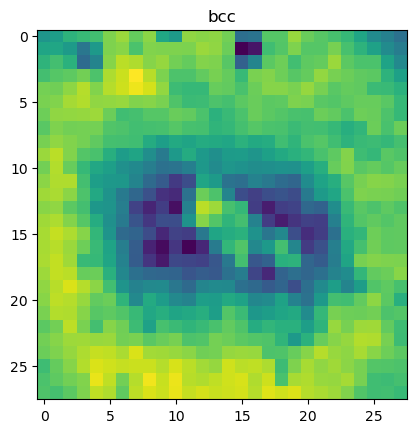

In [127]:
plt.imshow(images[1096])
plt.title(label_mapping[y[1096]])

Actually we see the difference between the images. 

## 3. Machine Learning Part 

The chief proposed to you, first of all a simple KNN as we saw last year with you :). 

And for the dish a little LightGBM Classifier. We actually use it in our P5A, but never used in the classifier application. 

### <span style="color:#055C9D"> KNeihbors  </span> 

In [128]:
## Librairies needed to implement KNN. 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix # metrics error

Train-test split : separating the dataset between validation and training. 


In [130]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)

In [131]:
# since its a multi-class prediction, in order to prevent error we need some library
from sklearn.multiclass import OneVsRestClassifier 

Need some information about it. 

In [132]:
knn = OneVsRestClassifier(KNeighborsClassifier(weights='distance', n_neighbors=9)) #Avoid the error during the fit of the knn. The number of neighbors is quite the most efficient

Fit the data

In [133]:
knn.fit(X_train, y_train)

OneVsRestClassifier(estimator=KNeighborsClassifier(n_neighbors=9,
                                                   weights='distance'))

Compute the predictions

In [134]:
predictions_knn = knn.predict(X_test)

Compute the accuracy 

In [135]:
print('KNN Accuracy: %.3f' % accuracy_score(y_test,predictions_knn)) 

KNN Accuracy: 0.679


Find the best parameters

In [136]:
param_grid = {'n_neighbors' : np.arange(1, 50 )}
knn = (KNeighborsClassifier(weights='distance')) #Avoid the error during the fit of the knn. The number of neighbors is quite the most efficient
knn_cv = GridSearchCV(knn, param_grid, cv = 5)
knn_cv.fit(X_train, y_train)
knn_cv.best_params_

{'n_neighbors': 9}

In [152]:
#print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

accuracy : 0.6814550641940086


For a simple multi class-classifier like that, it's quite fine to have a 68,15% of good predictions. The best parameter on n_neighbors is 9. 

### <span style="color:#055C9D"> Losgistic regression Classifier  </span> 

In [146]:
X = np.array(X)
X = X.reshape(10015,784)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=42)



In [ ]:
grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge
logreg=LogisticRegression()
logreg_cv=GridSearchCV(logreg,grid,cv=10)
logreg_cv.fit(X_train,y_train)

In [153]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 10.0, 'penalty': 'l2'}
accuracy : 0.6760342368045649


In [ ]:
lr = LogisticRegression('C' : 10.0, 'penalty' : 'l2')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)


In [99]:
print('KNN Accuracy: %.3f' % accuracy_score(y_test,y_pred)) 

KNN Accuracy: 0.665


### <span style="color:#055C9D"> LightGBM Classifier  </span> 

Here's one of the most common tree algorithm used today. It works a little bit different but it's quite interesting to see something we don't used to. 

Perhaps have to preprocess the image differently. Cross validation to see if the model is rigid (question for him)

In [428]:
#from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

#Necessary libraries for the LightGMB
from lightgbm.sklearn import LGBMClassifier
import lightgbm as lgbmr

In [424]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=42)

In [425]:
# defining parameters 
params = {
    'boosting': 'gbdt',
    'objective': 'multiclass',
    'num_leaves': 10,
    'num_class': 7
} 


lgb_train = lgbmr.Dataset(X_train, y_train)
lgb_eval = lgbmr.Dataset(X_test, y_test, reference=lgb_train)

model = lgbmr.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                num_boost_round = 300,
                 early_stopping_rounds=30)


c:\Users\mathi\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


ValueError: Input numpy.ndarray must be 2 dimensional

In [53]:
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)
cr = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
 
print(cr)
#print(cm) 

              precision    recall  f1-score   support

           0       0.19      0.08      0.12        96
           1       0.38      0.18      0.25       143
           2       0.41      0.21      0.28       350
           3       0.50      0.03      0.05        39
           4       0.74      0.96      0.83      1997
           5       0.00      0.00      0.00        33
           6       0.47      0.13      0.21       347

    accuracy                           0.69      3005
   macro avg       0.38      0.23      0.25      3005
weighted avg       0.62      0.69      0.63      3005



c:\Users\mathi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mathi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mathi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The fifth class got some problem with the classification. 
Let's improve this model a little it's the best we have for now. 

## 4. Neural Network 

In this part we'll use the classic keras classification with a convolution 2d as we saw in class (with some plots). 

Modeling the neural network : https://www.analyticsvidhya.com/blog/2021/06/image-classification-using-convolutional-neural-network-with-python/

In [172]:
y = data['label'].copy()
X = data.drop('label', axis=1).copy()

X = np.array(X)
X = X.reshape(10015,28,28,1)
#Scaled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)


### Callbacks

In [138]:
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [174]:
model =tf.keras.models.Sequential([
    #tf.keras.layers.GaussianBlur(sigma=(0, 3.0)),
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu" , input_shape = (28, 28, 1)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(64,(3,3),activation = "relu") , 
    #tf.keras.layers.Conv2D(64,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128,(3,3),activation = "relu") ,  
    #tf.keras.layers.Conv2D(128,(3,3),activation = "relu") ,  
    tf.keras.layers.MaxPooling2D(2,2),
    #
    # tf.keras.layers.BatchNormalization(),
  
    
    #tf.keras.layers.Conv2D(256,(3,3),activation = "relu") , 
    #tf.keras.layers.Conv2D(256,(3,3),activation = "relu") , 
    #tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate = 0.2),
    # tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.GlobalAveragePooling2D(),
    
    #tf.keras.layers.Dense(units = 256, activation = 'relu'), 
    #tf.keras.layers.BatchNormalization(),
    
    #tf.keras.layers.Dense(units = 128, activation = 'relu'), 
    #tf.keras.layers.BatchNormalization(),
    
    #tf.keras.layers.Dense(units = 64, activation = 'relu'), 
    #tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Flatten(), #Convert 3d in 1d features vectors 
    #tf.keras.layers.Dense(64, activation='relu'),  
    tf.keras.layers.Dropout(0.5), 
    tf.keras.layers.Dense(7,activation = "softmax")])

In [ ]:
#model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100,callbacks = [early], validation_data=(X_val, y_val))
#history = model.fit(X_train, y_train, epochs=100,callbacks = [early])

In [180]:
model_acc = model.evaluate(X_test, y_test)[1]

print("Test Accuracy: {:.3f}%".format(model_acc * 100))

94/94 [==============================] - 0s 4ms/step - loss: 1.3518 - accuracy: 0.6978
Test Accuracy: 69.784%


Let's plot the accuracy and the loss

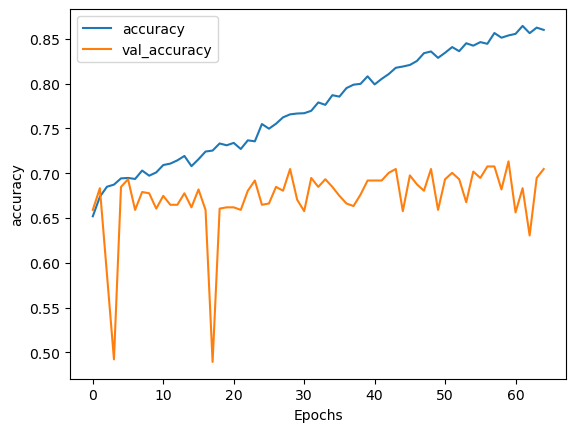

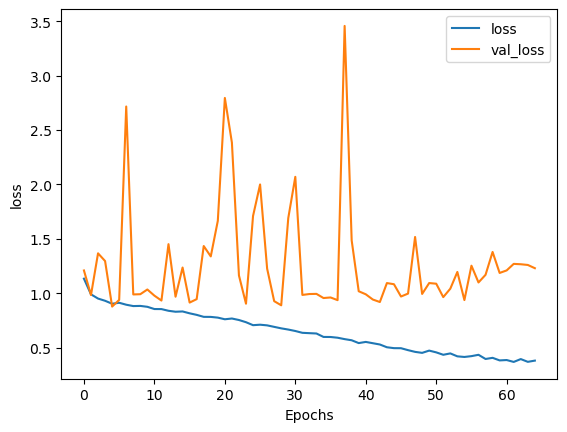

In [181]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [182]:
y_true = np.array(y_test)

y_pred = model.predict(X_test)
y_pred = np.array(list(map(lambda x: np.argmax(x), y_pred)))

cm = confusion_matrix(y_true, y_pred)
clr = classification_report(y_true, y_pred, target_names=label_mapping.values())

c:\Users\mathi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mathi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mathi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


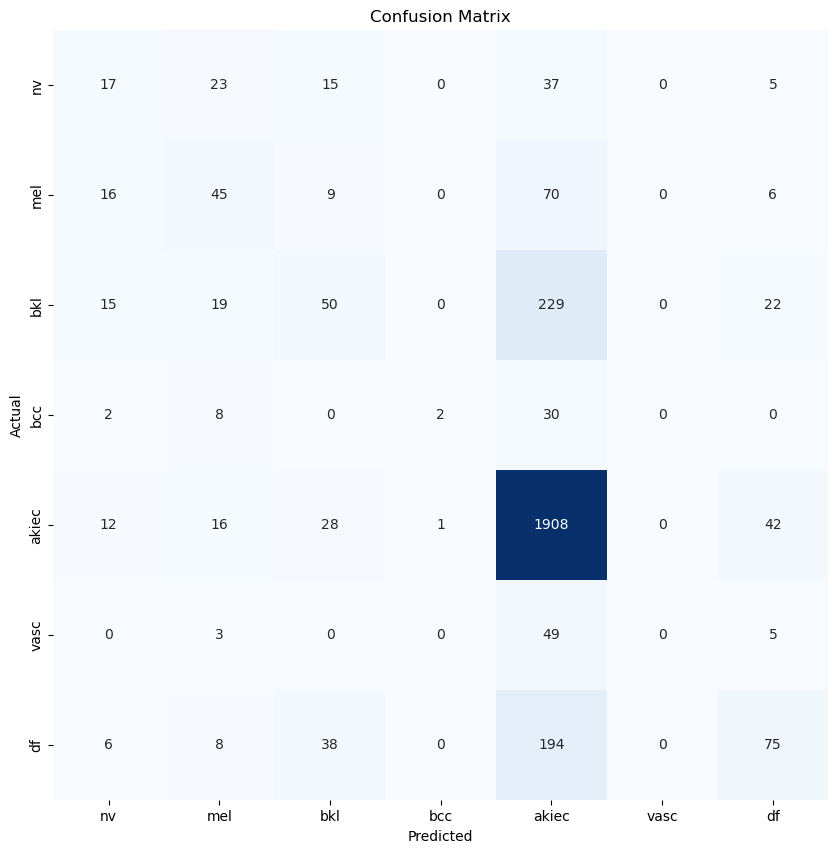

In [183]:
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=False, cmap='Blues')

plt.xticks(np.arange(7) + 0.5, label_mapping.values())
plt.xlabel("Predicted")

plt.yticks(np.arange(7) + 0.5, label_mapping.values())
plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

The early stopping stopped the model at the 10th epochs. Let's see how much accuracy do we have

With the classic CNN and some CNN and pooling we have 68,2 % Which is better than the KNeighbors but not better than the LightGMB 

# 5. Data Augmentation

Ma demarche va etre dans un premier temps d'augmenter le dataset des classes moins representé

class_weight à mettre sur les modèles de machine learning. 

Optimization : Data augmented note have any class on the 1,2,3,4

In [ ]:
#U-net or Resnet 

In [497]:
#Data augmentation : 
tf.keras.layers.experimental.preprocessing.RandomFlip

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomCrop(28,28)
])




Try the data augmention 

In [498]:
def augmentation_of_data(number_of_label) :
    data_filtered = data[data['label']== number_of_label ] 
    
    #Separate the X_new 
    
    y_new = data_filtered['label'].copy()
    X_new = data_filtered.drop('label', axis=1).copy()
    X_new_columns = X_new.columns
    
    #Creation of the new_images
    X_new = np.array(X_new)
    images = X_new.reshape(-1, 28, 28, 1)
    
    for i in range(len(images)) : 
        new_images = data_augmentation(images) 
    
    plt.imshow(new_images[2])
    
    #Shape = new_images.shape
    X_aug = np.array(new_images).reshape(len(new_images), 784)
    #y_aug = y_new.reshape(len(new_images),1)
    #new_images_array = pd.DataFrame(new_images)
    
    #Assign a value to the column 785
    

    #print(X_aug.shape)
    #print(len(X_aug), len(y_new))
    X_aug = pd.DataFrame(X_aug,columns=X_new_columns)
    #print(X_aug)
    # y_aug = pd.DataFrame(y_new, columns = ['label'])
    
    #Almost, merge was good but it's weird
    
    # X_aug = pd.merge(X_aug, y_new, left_index = True, right_index = True)
    X_aug['label'] = number_of_label
    #X_new = pd.DataFrame(X_new)
    #X_aug = pd.concat((X_new, y_new))
    #X_aug_labels = pd.concat(())
        
    return X_aug
    


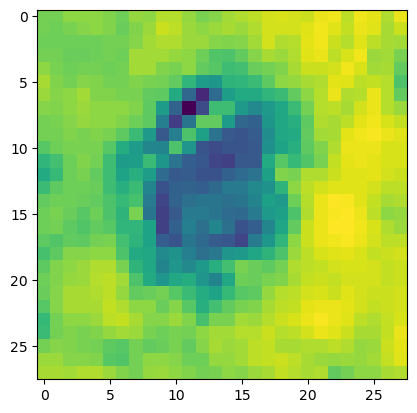

In [499]:
X1 = augmentation_of_data(1)
X0 = augmentation_of_data(0)
X5 = augmentation_of_data(5)
X3 = augmentation_of_data(3)

In [500]:
frames = [data, X1, X0, X5, X3]
new_data_aug = pd.concat(frames)


In [501]:
y = new_data_aug['label'].copy()
X = new_data_aug.drop('label', axis=1).copy()

In [507]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=42)

#Add some class weight 

class_weight = [{0:4, 1:3, 2: 4, 3 : 15, 4 : 1, 5 : 15, 6 : 5 }]

# defining parameters 
params = {
    'boosting': 'gbdt',
    'class_weight' : 'class_weight',
    'objective': 'multiclass',
    'num_leaves': 10,
    'num_class': 7
} 


lgb_train = lgbmr.Dataset(X_train, y_train)
lgb_eval = lgbmr.Dataset(X_test, y_test, reference=lgb_train)

model = lgbmr.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                num_boost_round = 300,
                 early_stopping_rounds=30)



c:\Users\mathi\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 144315
[LightGBM] [Info] Number of data points in the train set: 7779, number of used features: 784
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Start training from score -2.841086
[LightGBM] [Info] Start training from score -2.347142
[LightGBM] [Info] Start training from score -2.319307
[LightGBM] [Info] Start training from score -3.915758
[LightGBM] [Info] Start training from score -0.505782
[LightGBM] [Info] Start training from score -3.645977
[LightGBM] [Info] Start training from score -2.316696
[1]	valid_0's multi_logloss: 1.27121
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.23653
[3]	valid_0's multi_logloss: 1.207

In [508]:
import seaborn as sn

              precision    recall  f1-score   support

           0       0.43      0.23      0.30       200
           1       0.44      0.39      0.41       284
           2       0.38      0.23      0.28       334
           3       0.50      0.08      0.14        75
           4       0.72      0.94      0.82      2014
           5       1.00      0.02      0.05        81
           6       0.47      0.18      0.26       346

    accuracy                           0.66      3334
   macro avg       0.56      0.30      0.32      3334
weighted avg       0.62      0.66      0.61      3334



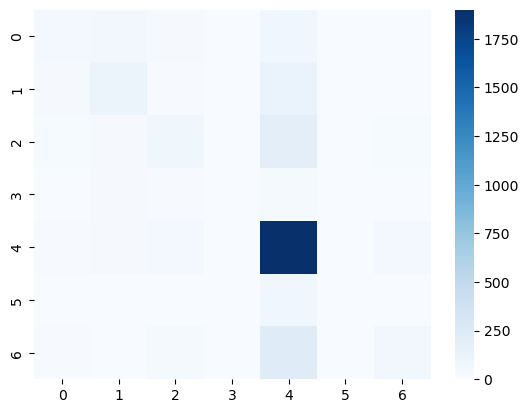

In [509]:
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)
cr2 = classification_report(y_test, y_pred)
cm2 = confusion_matrix(y_test, y_pred)
sn.heatmap(cm, cmap='Blues')
print(cr)
#print(cm) 

In [506]:
#State of art : 

#Second try : cr1, cm1

('              precision    recall  f1-score   support\n\n           0       0.43      0.23      0.30       200\n           1       0.44      0.39      0.41       284\n           2       0.38      0.23      0.28       334\n           3       0.50      0.08      0.14        75\n           4       0.72      0.94      0.82      2014\n           5       1.00      0.02      0.05        81\n           6       0.47      0.18      0.26       346\n\n    accuracy                           0.66      3334\n   macro avg       0.56      0.30      0.32      3334\nweighted avg       0.62      0.66      0.61      3334\n',
 array([[  46,   57,   25,    1,   69,    0,    2],
        [  26,  110,   14,    2,  126,    0,    6],
        [  15,   24,   76,    0,  197,    0,   22],
        [   3,   25,    9,    6,   32,    0,    0],
        [   9,   26,   41,    0, 1900,    0,   38],
        [   0,    5,    1,    0,   70,    2,    3],
        [   8,    1,   36,    3,  236,    0,   62]], dtype=int64))

Some improvement ! 

State of art : Without weighted : 0.22

Problem class 5 and 3 are not classified 

In [470]:
#Reduction of the higher class ! Let's reduce it by 1/4
data_to_reduce = new_data_aug[new_data_aug['label']== 4]
data_to_reduce = data_to_reduce.sample(frac=0.25, replace=True, random_state=0)


In [478]:
new_data_aug = new_data_aug[new_data_aug['label'].isin([0,1,2,3,5,6])]
new_data_aug.label.value_counts()


6    1113
2    1099
1    1028
0     654
5     284
3     230
Name: label, dtype: int64

In [481]:
new_df_reduced = pd.concat((new_data_aug, data_to_reduce))
new_df_reduced

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,pixel0010,pixel0011,pixel0012,pixel0013,pixel0014,pixel0015,pixel0016,pixel0017,pixel0018,pixel0019,pixel0020,pixel0021,pixel0022,pixel0023,pixel0024,pixel0025,pixel0026,pixel0027,pixel0028,pixel0029,pixel0030,pixel0031,pixel0032,pixel0033,pixel0034,pixel0035,pixel0036,pixel0037,pixel0038,pixel0039,...,pixel0745,pixel0746,pixel0747,pixel0748,pixel0749,pixel0750,pixel0751,pixel0752,pixel0753,pixel0754,pixel0755,pixel0756,pixel0757,pixel0758,pixel0759,pixel0760,pixel0761,pixel0762,pixel0763,pixel0764,pixel0765,pixel0766,pixel0767,pixel0768,pixel0769,pixel0770,pixel0771,pixel0772,pixel0773,pixel0774,pixel0775,pixel0776,pixel0777,pixel0778,pixel0779,pixel0780,pixel0781,pixel0782,pixel0783,label
0,169,171,170,177,181,182,181,185,194,192,188,190,185,181,188,189,182,180,171,171,178,156,151,157,151,159,167,165,177,176,176,176,179,186,170,182,198,190,196,191,...,179,175,179,186,189,186,153,137,146,164,171,149,167,169,166,171,175,193,198,199,197,185,172,188,199,199,194,191,184,176,184,186,185,180,157,140,140,159,165,2
1,19,57,105,140,149,148,144,155,170,170,182,183,180,179,180,179,180,173,167,171,171,171,160,150,126,102,63,46,34,81,124,149,155,135,136,155,167,182,190,191,...,196,184,172,173,155,145,131,113,68,27,16,50,51,74,109,129,141,163,183,179,175,183,183,177,176,179,188,184,185,181,172,175,160,144,114,89,47,18,18,2
2,155,163,161,167,167,172,155,152,165,175,175,164,170,171,158,143,144,136,154,167,168,171,165,158,150,147,138,116,163,164,167,156,153,158,167,171,184,190,170,161,...,190,177,163,165,166,166,171,165,154,143,127,151,153,150,165,173,173,177,177,181,182,186,187,189,189,188,184,187,185,162,163,178,157,166,167,148,141,136,115,2
3,25,71,116,139,136,153,148,161,172,162,159,176,173,169,156,159,170,164,163,159,164,161,156,144,127,93,57,40,48,97,136,151,148,155,161,169,176,161,151,170,...,166,166,148,148,144,141,125,97,56,20,14,43,47,70,97,128,144,151,157,159,161,167,160,161,163,164,151,161,170,142,125,135,138,137,111,71,32,16,16,2
4,129,162,181,196,205,208,205,213,225,224,222,227,233,230,231,230,241,239,244,247,242,238,239,239,233,211,180,144,145,173,187,195,203,210,210,213,224,224,222,230,...,206,214,209,206,182,197,203,205,205,179,131,99,139,177,193,201,206,197,185,201,197,205,210,214,212,215,209,205,207,211,210,197,172,190,195,193,181,147,88,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8289,183,185,189,195,192,181,183,188,179,177,178,180,187,180,179,192,190,199,193,199,196,195,192,191,193,193,190,190,186,187,183,186,189,181,190,197,183,172,181,186,...,193,190,184,185,186,187,194,197,198,201,197,171,182,182,184,185,189,188,186,184,190,187,182,191,192,190,192,198,197,191,187,186,188,186,196,199,198,200,197,4
6939,153,165,168,172,174,178,181,181,184,186,188,187,186,185,187,185,182,177,174,175,171,165,158,155,151,143,126,81,159,168,170,171,178,182,182,184,183,183,187,191,...,176,173,168,159,151,148,143,137,124,113,84,148,155,157,161,163,166,171,171,171,175,176,173,174,176,177,180,172,174,172,166,159,150,141,138,129,122,103,63,4
5177,168,169,166,167,167,165,162,164,167,166,166,169,168,164,167,169,169,168,167,166,166,161,168,171,170,171,171,169,166,165,164,165,164,161,163,165,164,162,163,164,...,161,165,161,160,163,162,163,162,163,162,160,154,154,150,147,141,142,145,150,150,154,154,153,156,159,159,159,163,163,159,160,163,162,160,161,162,161,162,159,4
4467,174,171,174,176,177,177,178,176,174,175,176,180,180,177,178,178,176,176,178,174,174,182,179,176,178,173,176,179,172,173,177,176,176,175,175,176,175,175,177,177,...,173,173,176,176,178,176,177,177,178,174,172,164,163,164,165,164,166,168,170,169,171,169,168,170,170,169,171,171,173,175,176,175,173,174,176,1

Our dataframe is reduced and augmented

In [482]:
y = new_df_reduced['label'].copy()
X = new_df_reduced.drop('label', axis=1).copy()

In [484]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30,random_state=42)

#Add some class weight 

class_weight = [{0:4, 1:3, 2: 4, 3 : 7, 4 : 1, 5 : 7, 6 : 5 }]

# defining parameters 
params = {
    'boosting': 'gbdt',
    'class_weight' : 'class_weight',
    'objective': 'multiclass',
    'num_leaves': 10,
    'num_class': 7
} 


lgb_train = lgbmr.Dataset(X_train, y_train)
lgb_eval = lgbmr.Dataset(X_test, y_test, reference=lgb_train)

model = lgbmr.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval,
                num_boost_round = 300,
                 early_stopping_rounds=30)



c:\Users\mathi\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 131689
[LightGBM] [Info] Number of data points in the train set: 4258, number of used features: 784
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Start training from score -2.205952
[LightGBM] [Info] Start training from score -1.767628
[LightGBM] [Info] Start training from score -1.735149
[LightGBM] [Info] Start training from score -3.372948
[LightGBM] [Info] Start training from score -1.281592
[LightGBM] [Info] Start training from score -3.038435
[LightGBM] [Info] Start training from score -1.698544
[1]	valid_0's multi_logloss: 1.73809
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.69557
[3]	valid_0's multi_logloss: 1.661

In [486]:
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=1)
cr = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
 
print(cr)
print(cm) 

              precision    recall  f1-score   support

           0       0.35      0.33      0.34       185
           1       0.46      0.59      0.52       301
           2       0.43      0.42      0.43       348
           3       0.14      0.02      0.04        84
           4       0.56      0.69      0.62       494
           5       0.33      0.05      0.09        80
           6       0.47      0.40      0.44       334

    accuracy                           0.48      1826
   macro avg       0.39      0.36      0.35      1826
weighted avg       0.45      0.48      0.45      1826

[[ 61  68  34   2  14   2   4]
 [ 35 179  37   5  33   1  11]
 [ 35  47 146   2  62   0  56]
 [ 19  30  16   2  12   0   5]
 [ 10  35  38   2 343   1  65]
 [  3  21   6   0  37   4   9]
 [ 12  12  59   1 111   4 135]]


Let's compute optimum class weight

### Transfert Learning : VGG16 : https://www.kaggle.com/code/viratkothari/image-classification-of-mnist-using-vgg16/notebook

In [97]:
def vgg16_model (num_classes = None ) :
    model = VGG16(weights = 'imagenet', include_top = True, input_shape = (28, 28, 1))
    x = tf.keras.layers.Dense(1024, activation = 'relu')(model.layers[-4].output)
    x = tf.keras.layers.Dropout(0.7)(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(7, activation = 'softmax')(x)
    model = tf.keras.models.Model(model.input, x)
    return model 


In [98]:
vgg_conv = vgg16_model(7)
for layer in vgg_conv.layers[:-10] :
    layer.trainable = False

NameError: name 'VGG16' is not defined